In [1]:
import os
import platform
import numpy
import pandas
import xarray
import netCDF4 as nc
import cartopy.crs
import cmocean
#import rioxarray
from array import *
from cmocean import cm as cmo
from glob import glob
from cartopy import crs,feature
import matplotlib as mpl
from matplotlib import pyplot as plt, patches, colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path
# used to make subplot labels consistent between figures
from matplotlib.offsetbox import AnchoredText
#from salishsea_tools import geo_tools, tidetools

In [2]:
# mapping specifications
rotated_crs = cartopy.crs.RotatedPole(pole_longitude=120.0, pole_latitude=63.75)
plain_crs = cartopy.crs.PlateCarree()
# linewidth for coast/rivers
lw=0.3
# reducd dpi to make smaller graphics
custom_dpi=600

## Create maps of spill locations by region
spill locations were determined in a crude way in [spillLocationsByImpactRegion.ipynb](https://github.com/MIDOSS/analysis-rachael/blob/main/notebooks/presentations/SSEC2022/spillLocationsByImpactRegion.ipynb) and saved to `yaml` files named `cwchn_SpillLocations.yaml`, `SOG_SpillLocations.yaml`,`lummi_SpillLocations.yaml`.

In [3]:
# load three .yaml files and calcluate max volume
import yaml
spillLocsByRegion={}
noImpact_spillLocsByRegion={}
input_yaml={}
input_noimpact_yaml={}
max_vol=0
yaml_dir = Path('/Users/rmueller/Projects/MIDOSS/results/try3/SpillLocationImpacts')
graphics_dir = yaml_dir


for region in ['sji']:
    input_yaml[region]=yaml_dir/f'{region}_SpillLocations.yaml'
    input_noimpact_yaml[region]=yaml_dir/f'{region}_NONESpillLocations.yaml'
    with open(input_yaml[region],'r') as file:
        spillLocsByRegion[region]=yaml.safe_load(file)
    with open(input_noimpact_yaml[region],'r') as file:
        noImpact_spillLocsByRegion[region]=yaml.safe_load(file)
    max_vol=max(numpy.max(spillLocsByRegion[region]['vol']),max_vol)

In [6]:
if platform.system()=='Darwin':
    base_dir = Path('/Users/rmueller/Data/SalishSeaCast/grid/')
else:
    base_dir = Path('/data/bmoorema/MEOPAR/grid/')
    
bathy = xarray.open_dataset(
    base_dir/'bathymetry_201702.nc', 
    decode_times=False
)
coords = xarray.open_dataset(
    base_dir/'coordinates_seagrid_SalishSea201702.nc', 
    decode_times=False
)
# Crop to Salish Sea
extent = [-126.5, -121.2, 46.8, 51.2]
lon, lat = [coords[var][0, ...].values for var in ('glamt', 'gphit')]

In [ ]:
## Create patch for SJI beaching selection boundary box
sog_box = numpy.array([
    [-124.7,49],[-122.6849,49],
    [-122.68,49.46],[-124.7,49.46]
])
#ax.add_patch(patches.Polygon(sog_box,fc='w', ec='k', alpha=0.5, lw=2.5, transform=proj_ref, zorder=2))

/Users/rmueller/opt/miniconda3/envs/monte-carlo/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1624: UserWarning: You passed a edgecolor/edgecolors ('slategrey') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  result = matplotlib.axes.Axes.scatter(self, *args, **kwargs)


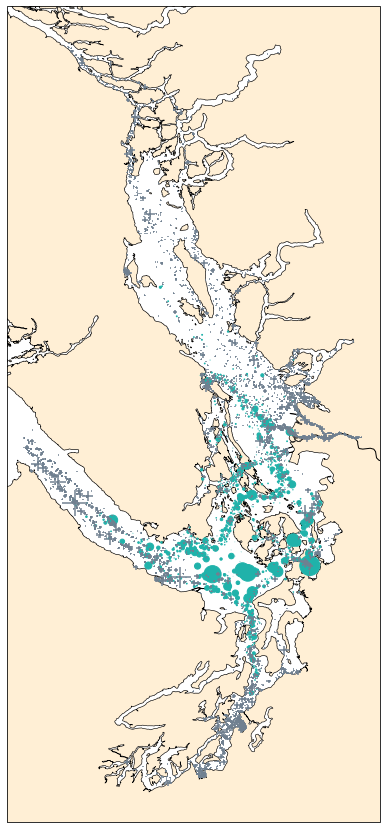

In [8]:
for region in ['sji']:
    # --------- Figure setup ---------
    proj_ref = crs.PlateCarree()
    lw = 1 # linewidth for regional boundary boxes
    fs = 12 #fontsize for colorbar

    # The code for this figure is a modified version of code from Ben Moore-Maley
    fig, ax = plt.subplots(1, 1, 
                  figsize=(10, 15), #(width, height)
                  subplot_kw={'projection': rotated_crs, 
                    "facecolor": "white"},
                  gridspec_kw={
                       'width_ratios': [1],
                       'height_ratios': [1],
                       'wspace': 0.1,
                      'hspace':-.2}
    )

    # --------- Left panel -----------
    # Make map
    extent = [-126.5, -121.2, 46.8, 51.2]
    proj = crs.Mercator(numpy.mean(extent[:2]), *extent[2:])
    #ax.set_extent([-124, -123.75, lat.min()-0.15, lat.max()])      
    ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', linewidth=0.6, facecolor='papayawhip'))
    ax.add_feature(feature.NaturalEarthFeature(
        category='physical', name='rivers_lake_centerlines',
        scale='10m', facecolor='none', edgecolor='k',
    ))
    # Overlay model domain
    #domain_box = numpy.array([(lon[ji], lat[ji]) for ji in [(0, 0), (0, -1), (-1, -1), (-1, 0)]])
    #c=ax.contourf(lon, lat, bathy.Bathymetry, levels=numpy.arange(0, 451, 50), cmap='Blues', extend='max', transform=proj_ref)
    #p=ax.add_patch(patches.Polygon(locals()[f'{region}_box'], fc='w', ec='k', alpha=0.5, lw=lw, transform=proj_ref, zorder=3))

    # do coordinate conversion of (x,y)
    xynps = ax.projection.transform_points(
        crs.Geodetic(), 
        numpy.array(spillLocsByRegion[region]['lon']), 
        numpy.array(spillLocsByRegion[region]['lat']))

    # ~~~ Number of spills ~~~
    # calculate histograms for number of spills and plot using pcolormesh
    s = [400*vol/max_vol for vol in spillLocsByRegion[region]['vol']]
    ax.scatter(
        xynps[:,0], 
        xynps[:,1],
        color='lightseagreen',
        marker='o',
        zorder=4,
        s=s
    );
    
    ## No spills
    
 # do coordinate conversion of (x,y)
    xynps = ax.projection.transform_points(
        crs.Geodetic(), 
        numpy.array(noImpact_spillLocsByRegion[region]['lon']), 
        numpy.array(noImpact_spillLocsByRegion[region]['lat']))

    # ~~~ Number of spills ~~~
    # calculate histograms for number of spills and plot using pcolormesh
    s = [400*vol/max_vol for vol in noImpact_spillLocsByRegion[region]['vol']]
    ax.scatter(
        xynps[:,0], 
        xynps[:,1],
        marker='+',
        facecolors='slategrey', 
        edgecolors='slategrey',
        zorder=4,
        s=s
    );

#     cbar=fig.colorbar(c, 
#         ax=ax, 
#         pad=0.05, shrink=0.8,
#         location='right', 
#     label='Depth (m)')
#     labels=numpy.arange(0,450,50)
#     cbar.set_ticks(labels)
    
#     if custom_dpi>=600:
#         plt.savefig(graphics_dir/f'spillLocations_byRegion_{region}.png')
#     else:
#         plt.savefig(graphics_dir/f'spillLocations_byRegion_{region}.png')



ValueError: s must be a scalar, or float array-like with the same size as x and y

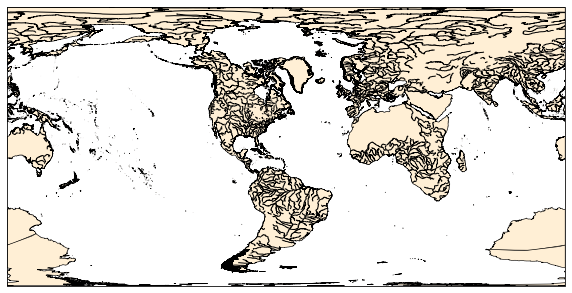

In [21]:
for region in ['sji']:
    # --------- Figure setup ---------
    proj_ref = crs.PlateCarree()
    lw = 1 # linewidth for regional boundary boxes
    fs = 12 #fontsize for colorbar

    # The code for this figure is a modified version of code from Ben Moore-Maley
    fig, ax = plt.subplots(1, 1, 
                  figsize=(10, 15), #(width, height)
                  subplot_kw={'projection': rotated_crs, 
                    "facecolor": "white"},
                  gridspec_kw={
                       'width_ratios': [1],
                       'height_ratios': [1],
                       'wspace': 0.1,
                      'hspace':-.2}
    )

    # --------- Left panel -----------
    # Make map
    extent = [-126.5, -121.2, 46.8, 51.2]
    proj = crs.Mercator(numpy.mean(extent[:2]), *extent[2:])
    #ax.set_extent([-124, -123.75, lat.min()-0.15, lat.max()])      
    ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', linewidth=0.6, facecolor='papayawhip'))
    ax.add_feature(feature.NaturalEarthFeature(
        category='physical', name='rivers_lake_centerlines',
        scale='10m', facecolor='none', edgecolor='k',
    ))
    # Overlay model domain
    #domain_box = numpy.array([(lon[ji], lat[ji]) for ji in [(0, 0), (0, -1), (-1, -1), (-1, 0)]])
    #c=ax.contourf(lon, lat, bathy.Bathymetry, levels=numpy.arange(0, 451, 50), cmap='Blues', extend='max', transform=proj_ref)
    #p=ax.add_patch(patches.Polygon(locals()[f'{region}_box'], fc='w', ec='k', alpha=0.5, lw=lw, transform=proj_ref, zorder=3))

    # do coordinate conversion of (x,y)
    xynps = ax.projection.transform_points(
        crs.Geodetic(), 
        numpy.array(noImpact_spillLocsByRegion[region]['lon']), 
        numpy.array(noImpact_spillLocsByRegion[region]['lat']))

    # ~~~ Number of spills ~~~
    # calculate histograms for number of spills and plot using pcolormesh
    s = [400*vol/max_vol for vol in spillLocsByRegion[region]['vol']]
    ax.scatter(
        xynps[:,0], 
        xynps[:,1],
        marker='o',
        facecolors='none', 
        edgecolors='magenta',
        zorder=4,
        s=s
    );

    cbar=fig.colorbar(c, 
        ax=ax, 
        pad=0.05, shrink=0.8,
        location='right', 
    label='Depth (m)')
    labels=numpy.arange(0,450,50)
    cbar.set_ticks(labels)
    
    if custom_dpi>=600:
        plt.savefig(graphics_dir/f'noImpact_spillLocations_byRegion_{region}.png')
    else:
        plt.savefig(graphics_dir/f'noImpact_spillLocations_byRegion_{region}.png')


